# Voluntary Problem Set

This problem set allows you to play around with concepts from class and to solve some smaller subproblems on your own.

Additional guidance is provided for concepts that did not make into our class discussion. 

# Topic: Testing whether one earns a daily risk premium in equity for exposure to volatility innovations

 

# Your Learning Points

you will practice 

- concepts of previous voluntary problem sets: Fama-MacBeth, Extracting Vol Shocks
$$
\\
$$

- High level introduction to the Intertemporal CAPM (in short: I-CAPM)
 

# Theory supporting what we are asked to do in the Problem Set

The CAPM postulates that positive (negative) exposure to market risk is the only reason why a stock pays a return that is on average higher (lower) than the risk-free rate.

Nobel laureate Prof. Robert Merton extends this theory to a dynamic context, using stochastic calculus. He shows that in a multiperiod context, not only market risk, but also exposure to factors that drive the level or slope of the Capital Allocation Line, is compensated by a risk premium. That theory is called Intertemporal CAPM or I-CAPM for short.

If you want to let you financial data science work be guided by economic theory, it is worthwhile to follow the thinking of the I-CAPM. Namely, a systematic risk factor that is not the market factor needs to drive level or slope of the Capital Allocation Line (risk-free rate or Sharpe ratio of the market portfolio). 

The problem set can be rephrased: Are innovations to volatility driving daily changes in the Capital Allocation Line? If so, then exposure to volatility innovations are compensated by a risk premium. Hence, we rely on the Fama-MacBeth method and on volatility innovations extracted from a SVM to answer this question.

$$
\\
$$

**If you want to understand the line of arguments better, have a look at some of our YT videos, especially:**

**Capital Allocation Line:** https://www.youtube.com/watch?v=oWv08pMqHak

**I-CAPM Application:** https://www.youtube.com/watch?v=RD-dW8dHnJw&t=198s



# Tasks 
$$
\\
$$

**Notice:**  **R_d.csv** contains merged data for FF7, Rf and SP500 constituents 

$$
\\
$$

 

**A.1**  Plot the daily normalized volatilities of the FF7 return factors into one graph.  

How important is each of the first five principal components?

 

 
**A.2** Which of the FF7 variances is the main driver of PC1(z(Vol(FF7))?  

 

$$
\\
$$

**B.1**  Are innovations to FF7 volatility priced in the cross-section of US equity returns?  

# Tasks ([Beginners])
$$
\\
$$

**Notice:**  **R_d.csv** contains merged data for FF7, Rf and SP500 constituents 

$$
\\
$$

 

**A.1**  Plot the daily normalized volatilities of the FF7 return factors into one graph.  

How important is each of the first five principal components?
 
 
**A.2** Which of the FF7 variances is the main driver of PC1(z(Vol(FF7))? Hint (beginner): GLS

 

$$
\\
$$

**B.1**  Are innovations to FF7 volatility priced in the cross-section of US equity returns? Hint (Beginners): Fama-MacBeth

 




In [64]:
#packages
import pandas as pd
import numpy as np
 
from sklearn.decomposition import PCA
from scipy import stats

from ipynb.fs.defs.Helper_SVM_Harvey import QLSV
from ipynb.fs.defs.Helper_FamaMacBeth import *

import matplotlib.pylab as plt

import statsmodels.api as sm

# Loading Data

In [65]:
R_d = pd.read_csv('R_d.csv',parse_dates=['Date'], index_col = 0)

In [66]:
r = pd.read_csv('R_d.csv', parse_dates=True, index_col=0)
r.dropna(inplace=True)

factors = ['SMB', 'HML', 'RMW', 'CMA_x', 'Mkt-RF', 'ST_Rev', 'Mom   ']
interest = ['RF_x']
f = r[factors]
rf = r[interest]

r.drop(factors + interest, inplace = True, axis = 'columns')

In [67]:
FF7_vol = f.copy()
FF7_volInnov = f.copy()
for i in range(0,f.shape[1]):
    SVM = QLSV(stats.zscore(f.iloc[:,i])).fit(cov_type='robust')
    FF7_vol.iloc[:,i] = np.exp(SVM.smoothed_state[0]/2)
    FF7_volInnov.iloc[:,i] = SVM.smoothed_state_disturbance.T
    

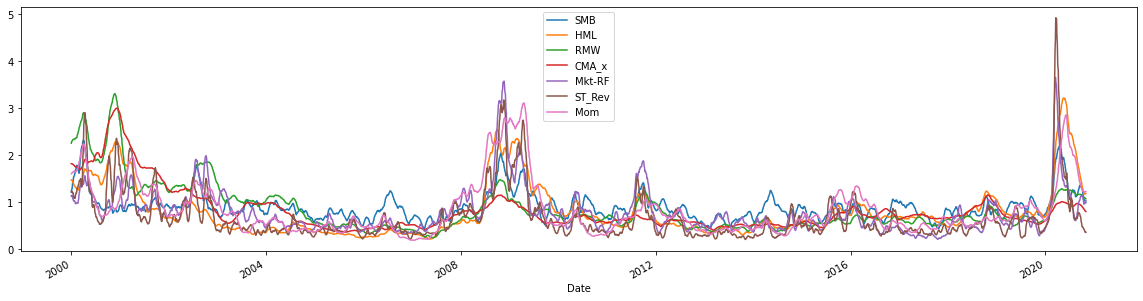

In [68]:
FF7_vol.plot(figsize=(20,5))

**Visual inspection: 3 factors drive all the variance in vol(FF7); another indication that FF7 risks are co-linear** 

In [69]:
#PCA: lambda / sum(lambda)

pca_FF7Vol = PCA().fit(stats.zscore(FF7_vol))

var_pca = pca_FF7Vol.explained_variance_ratio_

print(f"a1_pc1 = {var_pca[0]:.2f}\n\
a1_pc2 = {var_pca[1]:.2f}\n\
a1_pc3 = {var_pca[2]:.2f}\n\
a1_pc4 = {var_pca[3]:.2f}\n\
a1_pc5 = {var_pca[4]:.2f}")

a1_pc1 = 0.69
a1_pc2 = 0.15
a1_pc3 = 0.06
a1_pc4 = 0.05
a1_pc5 = 0.03


In [70]:
#PC1(vol)  

# A. 2

# get time series of most important pca

PC1_FF7Vol = PCA(n_components=1)
PC1_FF7Vol.fit(stats.zscore(FF7_vol))
PC1_FF7Vol_ = PC1_FF7Vol.transform(stats.zscore(FF7_vol))

# plt.plot(PC1_FF7Vol_)
 

In [71]:
# regress most important pca component onto vol panel
# which FF7_vol is most important for PC1(vol)?
fit1 = sm.GLS(PC1_FF7Vol_, sm.add_constant(stats.zscore(FF7_vol))).fit()
print(fit1.summary()) #due to co-linearity a multi-variate regression is not conclusive. all beta and t-stats are similar. 
 

                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            GLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.289e+33
Date:                Fri, 01 Jan 2021   Prob (F-statistic):               0.00
Time:                        12:00:04   Log-Likelihood:             1.7089e+05
No. Observations:                5241   AIC:                        -3.418e+05
Df Residuals:                    5233   BIC:                        -3.417e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.678e-16   2.31e-17      7.259      0.0

In [74]:
# how much R2 does MKT Variance explain?
for i in range(0,FF7_vol.shape[1]):
    print(f"{i}: {sm.GLS(PC1_FF7Vol_, sm.add_constant(stats.zscore(FF7_vol.iloc[:,i]))).fit().rsquared_adj:0.2f}")
    # univariate regressions show colinearity problem. Looking at point estimates, Reveral factor's variance is most important
    # yet, this analysis is flawed!!
    # LP: orthogonalize factors, how else to interpret results?

0: 0.67
1: 0.80
2: 0.59
3: 0.49
4: 0.73
5: 0.81
6: 0.74


# Soln B: Risk Premium in Stocks for Exposure to Vol?

In [75]:
FMacB = FMacBeth(r,pd.DataFrame(data=stats.zscore(FF7_volInnov), index=r.index), rf)

In [76]:
FMacB.TSRegression_step1()

In [77]:
FMacB.CSRegression_step2()

In [78]:
FMacB.t_lambdas_FB # zero evidence for vol being priced in equity returns

,0,1,2,3,4,5,6
MKT,0.000376,NaN,NaN,NaN,NaN,NaN,NaN
SMB,0.000370,NaN,NaN,NaN,NaN,NaN,NaN
HML,0.000056,NaN,NaN,NaN,NaN,NaN,NaN
RMW,0.000294,NaN,NaN,NaN,NaN,NaN,NaN
CMA,0.000014,NaN,NaN,NaN,NaN,NaN,NaN
Rev,0.000263,NaN,NaN,NaN,NaN,NaN,NaN
Mom,0.000190,NaN,NaN,NaN,NaN,NaN,NaN


## Step 2: Cross-Sectional Regression to get Lambda

In [79]:
FMacB.CSRegression_step2()

In [80]:
print(FMacB.lambdasR2.max())

0    0.531791
dtype: float64


In [81]:
print(FMacB.lambdasR2.idxmax())

0   2010-06-29
dtype: datetime64[ns]


In [49]:
print(FMacB.lambdas_FB*252*100) #annualized in %

            0
MKT  0.037287
SMB  1.022352
HML  1.006065
RMW  0.152178
CMA  0.798548
Rev  0.716387
Mom  0.517053


In [82]:
print(FMacB.t_lambdas_FB) #t(lambda)=0,

            0   1   2   3   4   5   6
MKT  0.000376 NaN NaN NaN NaN NaN NaN
SMB  0.000370 NaN NaN NaN NaN NaN NaN
HML  0.000056 NaN NaN NaN NaN NaN NaN
RMW  0.000294 NaN NaN NaN NaN NaN NaN
CMA  0.000014 NaN NaN NaN NaN NaN NaN
Rev  0.000263 NaN NaN NaN NaN NaN NaN
Mom  0.000190 NaN NaN NaN NaN NaN NaN


**realized lambdas are very noisy, a direct result of the low signal to noise ratio that daily returns have for expected returns**

Additional note: the realized lambda for market risk shares a 63 % correlation with the PC1(r). This confirms that lambda is simply tracking realized market returns, which on a daily basis are zero on average.